#### Classification | Model

# Predicting Heart Disease  

### Classification Model Stepwise Analysis

1. Research Question<br/>
2. DataFrames<br/>
3. Exploratory Data Analysis<br/>
   1 Data Summary<br/>
   2 Classification Viability<br/>
   3 Classification Metrics<br/>
4. Validation
5. Baseline<br/>
6. Feature Engineering<br/>
7. Class Imbalance Handling<br/>
8. Model Iterations<br/>
    1 Dummy Classifier<br/>
    2 Logistic Regression<br/>
    3 Decision Trees: Depth 2<br/>
    4 Decision Trees: Depth 4<br/>
    5 Random Forests<br/>
    6 Gradient Boosted Trees: xgboost<br/>
    7 Naive Bayes: Bernoulli<br/>
    8 Naive Bayes: Gaussian<br/>
    9 Naive Bayes: Multinomial<br/>
    10 Ensemble:  Naive Bayes Hard Voting Classifier<br/>
    11 Ensemble:  Naive Bayes Soft Voting Classifier<br/>
    12 Logistic regression: Question groups<br/>
    13 Logistic regression: Risk factors<br/>
    14 Logistic regression: Question groups + Risk factor features<br/>
    15 Logistic regression: threshold = 0.05<br/>
    16 Logistic regression: GridSearchCV<br/>
    17 Logistic regression: GridSearchCV + threshold = 0.05<br/>
9. Model: Predicting Heart Disease<br/>
    1 Select Model<br/>
    2 Evaluate Model<br/>
    3 Correlations<br/>
    4 Predictions


In [1]:
import pandas as pd
import numpy as np
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn
import pickle
import warnings

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline
sns.set_style("whitegrid")
np.set_printoptions(suppress=True)

from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


# **1 | Research Design**



* **Research Question:** What model can best predict patients' risk for heart disease?
* **Impact Hypothesis:** Reduce the number of patients who develop heart disease (arterial plaque or heart attack).
* **Data source:** [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease), n=319,795
* **Error metric:** [Recall](#3c) and [ROC AUC](#3c)

#### [Data Dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf)


_Target_
- `y_heart_disease`: Y/N | coronary heart disease (CHD) or myocardial infarction (MI)

_Health Behaviors_
- `behavior_activity`: Num (0-30) | # days did physical activity/ exercise other than regular job
- `behavior_alcohol`: Y/N | heavy drinker, defined as men: 14+/wk, women: 7+/wk (includes beer, wine, malt beverage, liquor)
- `behavior_sleep`: Num (0-24) | # hours of sleep in a 24-hour period, on average
- `behavior_tobacco`: Y/N | smoked at least 100 cigarettes in your life

_Demographics_
- `demg_age`: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+
- `demg_gender`: male/female
- `demg_race`: White, Black, Asian, American Indian/Alaskan Native, Hispanic, Other race

_Health Measures_
- `health_bmi`: Num | Body Mass Index (BMI)
- `health_physical`: Num (0-30) | # days physical health  not good, includes physical illness and injury
- `health_mental`: Num (0-30 ) | # days mental health not good, includes stress, depression, and problems with emotions
- `health_general`: Excellent, Very Good, Fair, Poor | Would you say that in general your health is...
- `health_mobility`: Y/N | serious difficulty walking or climbing stairs

_Chronic Disease_
- `disease_asthma`: Y/N
- `disease_diabetes`: Y/N/Y pregnancy/N borderline
- `disease_kidney`: Y/N | kidney disease, excludes kidney stones, bladder infection or incontinence
- `disease_skin`: Y/N | skin cancer
- `disease_stroke`: Y/N

# **2 | [DataFrames](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb)**

#### `heart_2020_cleaned_df`

In [2]:
# heart_2020_cleaned_df = pd.read_csv('/content/heart_2020_cleaned.csv')
# heart_2020_cleaned_df.describe().T.style.background_gradient(cmap='Blues')



*   [BMI](https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmi_tbl2.htm) range is 19-54
*   BMI max in `heart_2020_cleaned_df` is 94.85



In [3]:
# heart_2020_cleaned_df.info()

#### `heart_disease_df`

In [4]:
# heart_disease_df = pd.read_csv('/content/heart_disease_df.csv')
# heart_disease_df.head(3)

In [5]:
# heart_disease_df.describe().T.style.background_gradient(cmap='Blues')

#### `heart_disease_df_dmy`

In [6]:
# heart_disease_df_dmy = pd.read_csv('/content/heart_disease_df_dmy.csv')
# heart_disease_df_dmy.describe().T.style.background_gradient(cmap='Blues')

#### `heart_disease_df_map`

From [MVP EDA](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb) map Y/N to 1/0:
* behavior_activity ['Yes' 'No']
* behavior_alcohol ['No' 'Yes']
* behavior_tobacco ['Yes' 'No']
* disease_asthma ['Yes' 'No']
* disease_diabetes ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)'] #adjust in next cell
* disease_kidney ['No' 'Yes']
* disease_skin ['Yes' 'No']
* disease_stroke ['No' 'Yes']
* health_mobility ['No' 'Yes']
* y_heart_disease ['No' 'Yes']

`df_map = df_map.replace({'Yes': 1, 'No': 0})`

In [7]:
# load df from EDA for MVP
heart_disease_df_map = pd.read_csv('/content/heart_disease_df_map.csv')

# transformed df: mapped categorical variables to numerical values
heart_disease_df_map.head(3)

,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,1,0,5.0,1,55.0,1.0,6.0,1.0,1.0,0.0,1.0,0.0,16.60,4.0,30.0,0.0,3.0,0.0
1,1,0,7.0,0,80.0,1.0,6.0,0.0,0.0,0.0,0.0,1.0,20.34,4.0,0.0,0.0,0.0,0.0
2,1,0,8.0,1,65.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,26.58,2.0,30.0,0.0,20.0,0.0


# **3 | Exploratory Data Analysis**

*   Using `heart_disease_df_map` with mapped variables for modeling. (Full EDA part of [MVP](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb).)



### 3.1 Data Summary

In [8]:
# dataframe info
heart_disease_df_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88813 entries, 0 to 88812
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   behavior_activity  88813 non-null  int64  
 1   behavior_alcohol   88813 non-null  int64  
 2   behavior_sleep     88813 non-null  float64
 3   behavior_tobacco   88813 non-null  int64  
 4   demg_age           88812 non-null  float64
 5   demg_gender        88812 non-null  float64
 6   demg_race          88812 non-null  float64
 7   disease_asthma     88812 non-null  float64
 8   disease_diabetes   88812 non-null  float64
 9   disease_kidney     88812 non-null  float64
 10  disease_skin       88812 non-null  float64
 11  disease_stroke     88812 non-null  float64
 12  health_bmi         88812 non-null  float64
 13  health_general     88812 non-null  float64
 14  health_mental      88812 non-null  float64
 15  health_mobility    88812 non-null  float64
 16  health_physical    888

*   No missing values
*   All data types are numerical.

In [9]:
# # shift column 'C' to first position
# first_column = heart_disease_df_map.pop('y_heart_disease')

# # #insert column using insert(position,column_name,first_column) function
# heart_disease_df_map.insert(0, 'y_heart_disease', first_column)

# heart_disease_df_map.head(3)

In [10]:
# sns.pairplot(heart_disease_df_map, hue='demg_age');

### 3.2 Classification Viability

In [11]:
# descriptive statistics
heart_disease_df_map.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
behavior_activity,88813.000000,0.773096,0.418832,0.000000,1.000000,1.000000,1.000000,1.000000
behavior_alcohol,88813.000000,0.069224,0.253836,0.000000,0.000000,0.000000,0.000000,1.000000
behavior_sleep,88813.000000,7.100019,1.484007,1.000000,6.000000,7.000000,8.000000,24.000000
behavior_tobacco,88813.000000,0.415739,0.492852,0.000000,0.000000,0.000000,1.000000,1.000000
demg_age,88812.000000,52.542247,18.192682,18.000000,40.000000,55.000000,65.000000,80.000000
demg_gender,88812.000000,1.474238,0.499339,1.000000,1.000000,1.000000,2.000000,2.000000
demg_race,88812.000000,5.266000,1.307658,1.000000,5.000000,6.000000,6.000000,6.000000
disease_asthma,88812.000000,0.134734,0.341441,0.000000,0.000000,0.000000,0.000000,1.000000
disease_diabetes,88812.000000,0.218653,0.581405,0.000000,0.000000,0.000000,0.000000,3.000000
disease_kidney,88812.000000,0.038148,0.191555,0.000000,0.000000,0.000000,0.000000,1.000000


#### Correlation

In [12]:
# correlation matrix
heart_disease_df_map.corr().style.background_gradient(cmap='Blues')

,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
behavior_activity,1.000000,0.023618,-0.006167,-0.095732,-0.122910,0.052915,0.047253,-0.044237,-0.090431,-0.081434,-0.005352,-0.081040,-0.149340,0.286351,-0.095708,-0.284876,-0.243799,-0.108342
behavior_alcohol,0.023618,1.000000,-0.004481,0.112688,-0.057416,0.003943,0.042967,-0.003033,-0.040229,-0.027912,-0.003510,-0.019173,-0.038192,0.029020,0.052496,-0.034044,-0.014254,-0.028600
behavior_sleep,-0.006167,-0.004481,1.000000,-0.022230,0.101856,-0.012060,0.042143,-0.040085,-0.004128,0.006105,0.043720,0.015160,-0.045376,0.052165,-0.117191,-0.016602,-0.052692,0.010321
behavior_tobacco,-0.095732,0.112688,-0.022230,1.000000,0.133925,0.084814,0.079520,0.025842,0.035392,0.035835,0.040223,0.066537,0.022119,-0.172217,0.077987,0.126773,0.115333,0.111176
demg_age,-0.122910,-0.057416,0.101856,0.133925,1.000000,-0.070542,0.154943,-0.055282,0.143775,0.127041,0.276203,0.138451,-0.004101,-0.192154,-0.151519,0.242737,0.113482,0.230880
demg_gender,0.052915,0.003943,-0.012060,0.084814,-0.070542,1.000000,0.019910,-0.064241,-0.022155,-0.017036,0.015631,-0.002541,0.026059,0.027904,-0.092817,-0.067137,-0.043318,0.065332
demg_race,0.047253,0.042967,0.042143,0.079520,0.154943,0.019910,1.000000,-0.019846,-0.069852,0.004935,0.158521,-0.010583,-0.035365,0.055790,-0.002435,-0.003784,0.008568,0.043677
disease_asthma,-0.044237,-0.003033,-0.040085,0.025842,-0.055282,-0.064241,-0.019846,1.000000,0.042234,0.040030,-0.005135,0.040304,0.093186,-0.134928,0.105489,0.099467,0.112837,0.038744
disease_diabetes,-0.090431,-0.040229,-0.004128,0.035392,0.143775,-0.022155,-0.069852,0.042234,1.000000,0.085048,0.018617,0.067042,0.150306,-0.189488,0.028799,0.146049,0.102488,0.111441
disease_kidney,-0.081434,-0.027912,0.006105,0.035835,0.127041,-0.017036,0.004935,0.040030,0.085048,1.000000,0.067381,0.087141,0.048136,-0.174698,0.036695,0.147568,0.145742,0.150561


In [13]:
# correlation matrix subset
heart_sub_corr = heart_disease_df_map[['y_heart_disease', 'demg_age', 'behavior_tobacco',
                      'health_physical', 'health_mobility',
                      'disease_diabetes','disease_kidney','disease_stroke']].corr()
heart_sub_corr.style.background_gradient(cmap='Blues')

,y_heart_disease,demg_age,behavior_tobacco,health_physical,health_mobility,disease_diabetes,disease_kidney,disease_stroke
y_heart_disease,1.000000,0.230880,0.111176,0.177637,0.207848,0.111441,0.150561,0.205194
demg_age,0.230880,1.000000,0.133925,0.113482,0.242737,0.143775,0.127041,0.138451
behavior_tobacco,0.111176,0.133925,1.000000,0.115333,0.126773,0.035392,0.035835,0.066537
health_physical,0.177637,0.113482,0.115333,1.000000,0.433445,0.102488,0.145742,0.145841
health_mobility,0.207848,0.242737,0.126773,0.433445,1.000000,0.146049,0.147568,0.176835
disease_diabetes,0.111441,0.143775,0.035392,0.102488,0.146049,1.000000,0.085048,0.067042
disease_kidney,0.150561,0.127041,0.035835,0.145742,0.147568,0.085048,1.000000,0.087141
disease_stroke,0.205194,0.138451,0.066537,0.145841,0.176835,0.067042,0.087141,1.000000


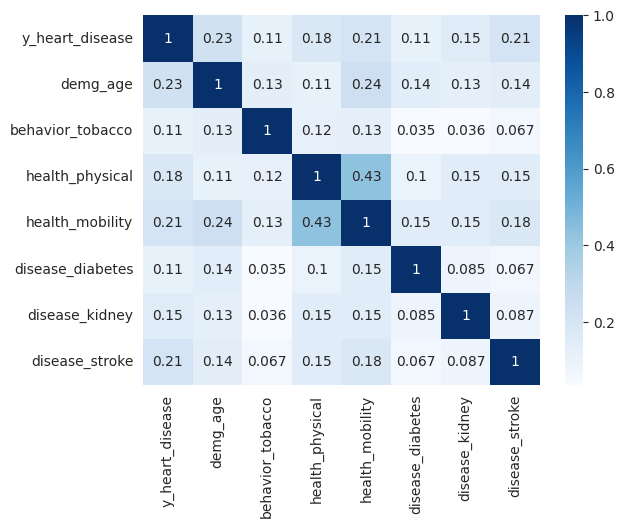

In [14]:
sns.heatmap(heart_sub_corr, annot=True, cmap='Blues');

*   A classification model is viable.




#### Boxplots

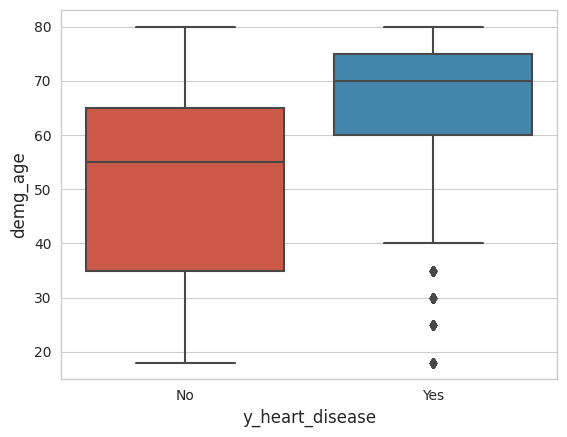

In [15]:
# target vs age
ax = sns.boxplot(x='y_heart_disease', y='demg_age', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


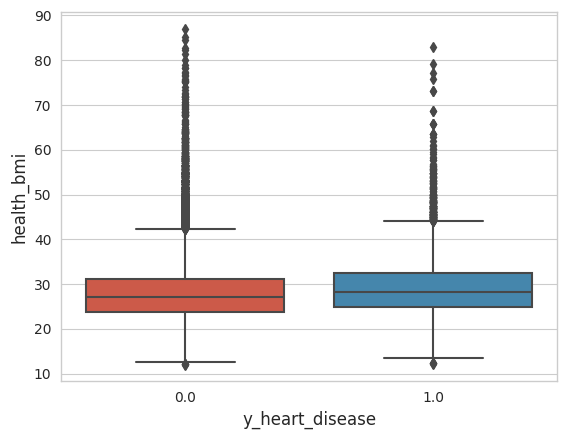

In [16]:
# target vs mobility
sns.boxplot(x='y_heart_disease', y='health_bmi', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


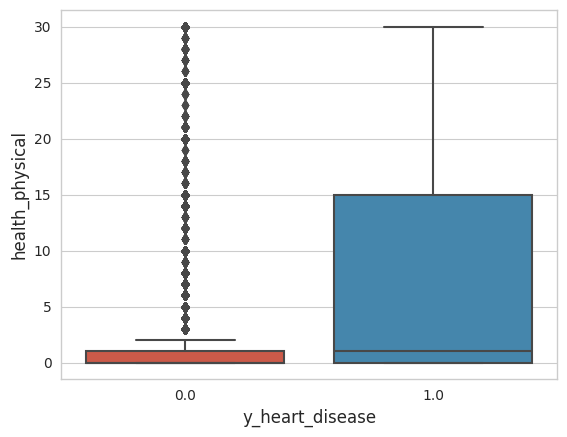

In [17]:
# target vs physical health
sns.boxplot(x='y_heart_disease', y='health_physical', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [18]:
# target distribution
print('Positives/Negatives Ratio:', round(27373/292422, 4) * 100, '%')
print(heart_disease_df_map['y_heart_disease'].value_counts())


Positives/Negatives Ratio: 9.36 %
0.0    81242
1.0     7570
Name: y_heart_disease, dtype: int64


#### BMI

In [19]:
print('unique health_bmi: ', heart_disease_df_map['health_bmi'].unique())
print('nunique health_bmi: ',heart_disease_df_map['health_bmi'].nunique())
print('max health_bmi: ',heart_disease_df_map['health_bmi'].max())


unique health_bmi:  [16.6  20.34 26.58 ... 60.69 53.73   nan]
nunique health_bmi:  2732
max health_bmi:  87.05


In [20]:
# Q. How many people reported a BMI higher than 54 (max range is 54 defined by NIH)?
heart_disease_df_map[heart_disease_df_map['health_bmi'] > 54]['health_bmi'].count()
# A. 1270 entries may have outlying BMI values.

# Q. Keep rows or drop? What's the distribution of BMI values?
# A. Keep, BMI looks to be normally distributed. Outliers are a small percentage of data.

366

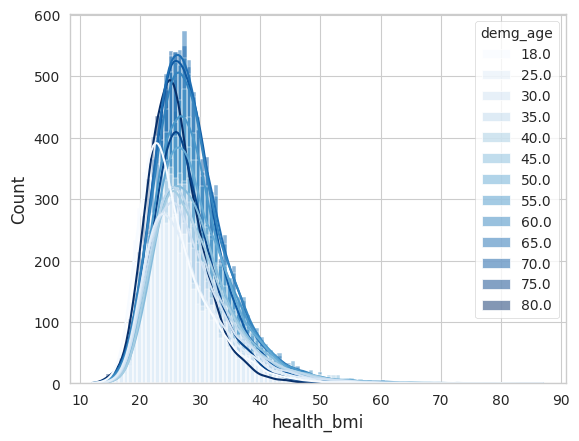

In [21]:
sns.histplot(x='health_bmi', hue='demg_age',
             kde=True, data=heart_disease_df_map, bins=100, palette='Blues');

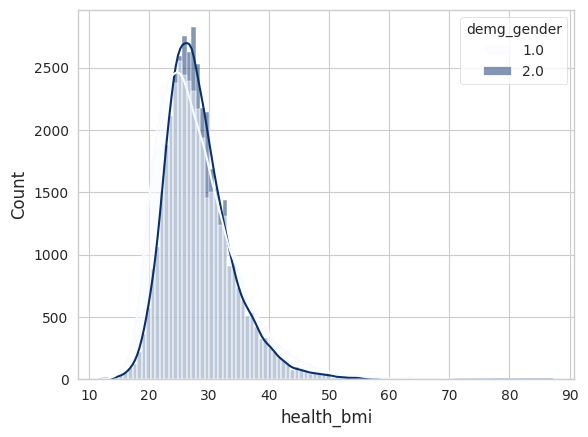

In [22]:
sns.histplot(x='health_bmi', hue='demg_gender',
             kde=True, data=heart_disease_df_map, bins=100, palette='Blues');

### 3.3 Evaluation Metrics

* **Recall** to maximize on patients who are true positives for heart disease.
* **ROC AUC** to identify high vs low risk patients.

# **4 | Validation**

Validation and testing scheme to use in [model selection](#7).

In [23]:
# separate target from features
y = heart_disease_df_map['y_heart_disease']
X = heart_disease_df_map.loc[:, [
    'behavior_activity',
    'behavior_alcohol',
    'behavior_sleep',
    'behavior_tobacco',
    'demg_age',
    'demg_gender',
    'demg_race',
    'disease_asthma',
    'disease_diabetes',
    'disease_kidney',
    'disease_skin',
    'disease_stroke',
    'health_bmi',
    'health_general',
    'health_mental',
    'health_mobility',
    'health_physical'
    ]]
# double split for test/train/validate
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = .25,
                                                  random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_scaled = scaler.transform(X)


# **5 | Baseline**

Logistic regression with three features based on correlation matrix.

In [24]:
# separate target from three features based on the correlation matrix
y_base = heart_disease_df_map['y_heart_disease']
X_base = heart_disease_df_map.loc[:, [
    'demg_age',
    'health_mobility',
    'health_physical']]

# double split for test/train/validate
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base,
                                             y_base,
                                             test_size=0.2,
                                             random_state=42)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train_base,
                                            y_train_base,
                                            test_size = .25,
                                            random_state = 42)
# scale baseline X train/test
scaler = StandardScaler()
X_train_scaled_base = scaler.fit_transform(X_train_base)
X_test_scaled_base = scaler.transform(X_test_base)
X_val_scaled_base = scaler.transform(X_val_base)
X_scaled_base = scaler.transform(X_base)


In [25]:
# baseline logistic regression X train scaled and y train
log_reg_base = LogisticRegression()
log_reg_base.fit(X_train_scaled_base, y_train_base)

# baseline predict on X_validate_scaled_m
y_pred_base = log_reg_base.predict(X_val_scaled_base)

In [26]:
# score on recall and roc auc
zero = ['Baseline logistic regression','log_reg_base',
        'Recall:', round(recall_score(y_val_base, y_pred_base), 4),
        'ROC AUC:',round(roc_auc_score(y_val_base, y_pred_base), 4)]
zero

['Baseline logistic regression',
 'log_reg_base',
 'Recall:',
 0.0247,
 'ROC AUC:',
 0.5104]

# **6 | Feature Engineering**

### Features: Question groups
Groups of similar survey question questions as defined by [data dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf).

In [27]:
# 1 behaviors = physical activity days/month + sleep time hrs/day + alcohol + tobacco use
heart_disease_df_map['behaviors'] = (
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'] +
    heart_disease_df_map['behavior_sleep'] +
    heart_disease_df_map['behavior_tobacco'])

# 2 demographics = age + gender + race
heart_disease_df_map['demographics'] = (
    heart_disease_df_map['demg_age'] +
    heart_disease_df_map['demg_gender'] +
    heart_disease_df_map['demg_race'])

# 3 disease = asthma + diabetes + kidney + skin cancer + stroke
heart_disease_df_map['disease'] = (
    heart_disease_df_map['disease_asthma'] +
    heart_disease_df_map['disease_diabetes'] +
    heart_disease_df_map['disease_kidney'] +
    heart_disease_df_map['disease_skin'] +
    heart_disease_df_map['disease_stroke'])

# 4 (health) measures = bmi + general health + mental + mobility + physical
heart_disease_df_map['measures'] = (
    heart_disease_df_map['health_bmi'] +
    heart_disease_df_map['health_general'] +
    heart_disease_df_map['health_mental'] +
    heart_disease_df_map['health_mobility'] +
    heart_disease_df_map['health_physical'])

heart_disease_df_map.columns


Index(['behavior_activity', 'behavior_alcohol', 'behavior_sleep',
       'behavior_tobacco', 'demg_age', 'demg_gender', 'demg_race',
       'disease_asthma', 'disease_diabetes', 'disease_kidney', 'disease_skin',
       'disease_stroke', 'health_bmi', 'health_general', 'health_mental',
       'health_mobility', 'health_physical', 'y_heart_disease', 'behaviors',
       'demographics', 'disease', 'measures'],
      dtype='object')

In [28]:
heart_disease_df_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88813 entries, 0 to 88812
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   behavior_activity  88813 non-null  int64  
 1   behavior_alcohol   88813 non-null  int64  
 2   behavior_sleep     88813 non-null  float64
 3   behavior_tobacco   88813 non-null  int64  
 4   demg_age           88812 non-null  float64
 5   demg_gender        88812 non-null  float64
 6   demg_race          88812 non-null  float64
 7   disease_asthma     88812 non-null  float64
 8   disease_diabetes   88812 non-null  float64
 9   disease_kidney     88812 non-null  float64
 10  disease_skin       88812 non-null  float64
 11  disease_stroke     88812 non-null  float64
 12  health_bmi         88812 non-null  float64
 13  health_general     88812 non-null  float64
 14  health_mental      88812 non-null  float64
 15  health_mobility    88812 non-null  float64
 16  health_physical    888

### Features: Risk factors
Heart disease risk factors as outlined by [CDC](https://www.cdc.gov/heartdisease/facts.htm).

In [29]:
# risk factors = diabetes + bmi + physical activity + alcohol
heart_disease_df_map['risk_factors'] = (
    heart_disease_df_map['disease_diabetes'] +
    heart_disease_df_map['health_bmi'] +
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'])

heart_disease_df_map.columns

Index(['behavior_activity', 'behavior_alcohol', 'behavior_sleep',
       'behavior_tobacco', 'demg_age', 'demg_gender', 'demg_race',
       'disease_asthma', 'disease_diabetes', 'disease_kidney', 'disease_skin',
       'disease_stroke', 'health_bmi', 'health_general', 'health_mental',
       'health_mobility', 'health_physical', 'y_heart_disease', 'behaviors',
       'demographics', 'disease', 'measures', 'risk_factors'],
      dtype='object')

In [30]:
# correlation matrix subset
heart_disease_df_map[['y_heart_disease',
                      'behaviors',
                      'demographics',
                      'disease',
                      'measures',
                      'risk_factors']].corr().style.background_gradient(cmap='Blues')

,y_heart_disease,behaviors,demographics,disease,measures,risk_factors
y_heart_disease,1.000000,0.010764,0.232987,0.209944,0.126687,0.054022
behaviors,0.010764,1.000000,0.098550,-0.013761,-0.128224,-0.058169
demographics,0.232987,0.098550,1.000000,0.233258,-0.032017,-0.003169
disease,0.209944,-0.013761,0.233258,1.000000,0.195958,0.199912
measures,0.126687,-0.128224,-0.032017,0.195958,1.000000,0.511606
risk_factors,0.054022,-0.058169,-0.003169,0.199912,0.511606,1.000000


In [31]:
heart_disease_df_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88813 entries, 0 to 88812
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   behavior_activity  88813 non-null  int64  
 1   behavior_alcohol   88813 non-null  int64  
 2   behavior_sleep     88813 non-null  float64
 3   behavior_tobacco   88813 non-null  int64  
 4   demg_age           88812 non-null  float64
 5   demg_gender        88812 non-null  float64
 6   demg_race          88812 non-null  float64
 7   disease_asthma     88812 non-null  float64
 8   disease_diabetes   88812 non-null  float64
 9   disease_kidney     88812 non-null  float64
 10  disease_skin       88812 non-null  float64
 11  disease_stroke     88812 non-null  float64
 12  health_bmi         88812 non-null  float64
 13  health_general     88812 non-null  float64
 14  health_mental      88812 non-null  float64
 15  health_mobility    88812 non-null  float64
 16  health_physical    888

# **7 | Class Imblance Handling** ⚠️

In [32]:
# # target imbalance
# heart_disease_df_map.y_heart_disease.value_counts()

In [33]:
# heart_disease_df_map.head()

# **8 | Model Iterations**

### 1 Dummy Classifier

In [34]:
clf = DummyClassifier(strategy= 'most_frequent')
clf.fit(X_train,y_train)
y_pred_clf = clf.predict(X_val_scaled)

In [35]:
one = ['Dummy classifier', 'clf',
        'Recall:', round(recall_score(y_val, y_pred_clf), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_clf), 4)]

one

['Dummy classifier', 'clf', 'Recall:', 0.0, 'ROC AUC:', 0.5]

### 2 Logistic Regression

In [36]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_val_scaled)
log_reg

LogisticRegression()

In [37]:
two = ["Logistic regression", 'log_reg',
        'Recall:', round(recall_score(y_val, y_pred_log_reg), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_log_reg), 4)]
two

['Logistic regression', 'log_reg', 'Recall:', 0.1099, 'ROC AUC:', 0.5503]

In [87]:
# confusion matrix for log_reg
cm_log_reg = confusion_matrix(y_val, y_pred_log_reg)
cm_log_reg

array([[16110,   152],
       [ 1336,   165]])

### 3 Decision Trees: Depth=2

In [39]:
dt_2 = DecisionTreeClassifier(max_depth=2,criterion="entropy")
dt_2.fit(X_train, y_train)
y_pred_dt_2 = dt_2.predict(X_val)
dt_2

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [40]:
three = ["Decision tree (depth=2)", 'dt_2',
        'Recall:', round(recall_score(y_val, y_pred_dt_2), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_dt_2), 4)]
three

['Decision tree (depth=2)', 'dt_2', 'Recall:', 0.0, 'ROC AUC:', 0.5]

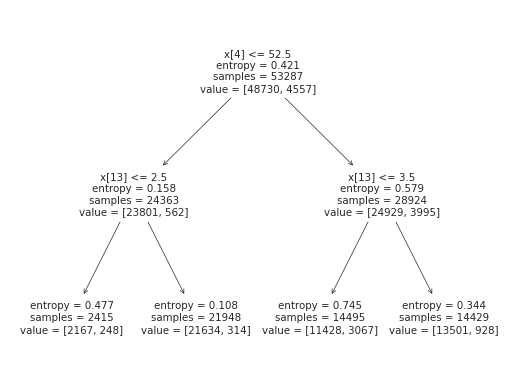

In [41]:
tree.plot_tree(dt_2);

### 4 Decision Trees: Depth=4

In [42]:
dt_4 = DecisionTreeClassifier(max_depth=4,criterion="entropy")
dt_4.fit(X_train, y_train)
y_pred_dt_4 = dt_4.predict(X_val)
dt_4

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [43]:
four = ["Decision tree (depth=4)", 'dt_4',
        'Recall:', round(recall_score(y_val, y_pred_dt_4), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_dt_4), 4)]
four

['Decision tree (depth=4)', 'dt_4', 'Recall:', 0.07, 'ROC AUC:', 0.5301]

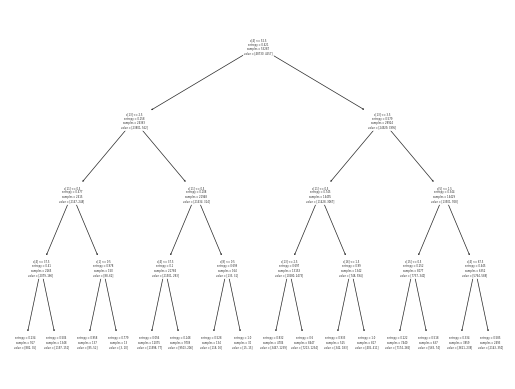

In [44]:
tree.plot_tree(dt_4);

### 5 Random Forests

In [45]:
forest = RandomForestClassifier().fit(X_train, y_train)
y_pred_forest = forest.predict(X_val)
forest

RandomForestClassifier()

In [46]:
five = ["Random forest", 'forest',
        'Recall:', round(recall_score(y_val, y_pred_forest), 4),
        'ROC AUC:', round(roc_auc_score(y_val, y_pred_forest), 4)]
five

['Random forest', 'forest', 'Recall:', 0.1019, 'ROC AUC:', 0.5438]

### 6 Gradient Boosted Trees: xgboost

In [47]:
gbm = xgb.XGBRegressor(
                    n_estimators=30000,
                    max_depth=3,
                    objective="binary:logistic",
                    eval_metric='auc',
                    learning_rate=.1,
                    subsample=1,
                    min_child_weight=1,
                    colsample_bytree=.8
                    )
eval_set=[(X_train, y_train),(X_val,y_val)]
gbm

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='auc', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=30000, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [48]:
gbm_fit = gbm.fit(X_train, y_train,
                  eval_set=eval_set,
                  early_stopping_rounds=20,
                  verbose=True)
y_pred_gbm = gbm.predict(X_val)

[0]	validation_0-auc:0.77063	validation_1-auc:0.76622
[1]	validation_0-auc:0.80232	validation_1-auc:0.79567
[2]	validation_0-auc:0.81101	validation_1-auc:0.80487
[3]	validation_0-auc:0.81030	validation_1-auc:0.80429
[4]	validation_0-auc:0.81692	validation_1-auc:0.81012
[5]	validation_0-auc:0.81702	validation_1-auc:0.81029
[6]	validation_0-auc:0.82177	validation_1-auc:0.81573
[7]	validation_0-auc:0.82189	validation_1-auc:0.81600
[8]	validation_0-auc:0.82889	validation_1-auc:0.82338
[9]	validation_0-auc:0.82993	validation_1-auc:0.82463
[10]	validation_0-auc:0.83098	validation_1-auc:0.82562
[11]	validation_0-auc:0.83080	validation_1-auc:0.82557
[12]	validation_0-auc:0.83363	validation_1-auc:0.82827
[13]	validation_0-auc:0.83387	validation_1-auc:0.82874
[14]	validation_0-auc:0.83397	validation_1-auc:0.82860
[15]	validation_0-auc:0.83392	validation_1-auc:0.82861
[16]	validation_0-auc:0.83438	validation_1-auc:0.82898
[17]	validation_0-auc:0.83461	validation_1-auc:0.82930
[18]	validation_0-au

In [49]:
# [216]	validation_0-auc:0.84859	validation_1-auc:0.84469

In [50]:
six = ["XGBoost", 'gbm',
        'Recall:', round(recall_score(y_val, np.round(y_pred_gbm)), 4),
        'ROC AUC:', round(roc_auc_score(y_val, np.round(y_pred_gbm)),4)]
six

['XGBoost', 'gbm', 'Recall:', 0.0966, 'ROC AUC:', 0.5446]

### 7 Naive Bayes: Bernoulli

In [51]:
bern = BernoulliNB().fit(X_train, y_train)
y_predict_bern = bern.predict(X_val)
bern

BernoulliNB()

In [52]:
seven = ["Bernoulli NB", 'bern',
        'Recall:', round(recall_score(y_val, y_predict_bern), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_predict_bern), 4)]
seven

['Bernoulli NB', 'bern', 'Recall:', 0.2572, 'ROC AUC:', 0.6068]

### 8 Naive Bayes: Gaussian

In [53]:
gaus = GaussianNB().fit(X_train, y_train)
y_pred_gaus = gaus.predict(X_val)
gaus

GaussianNB()

In [54]:
eight = ["Gaussian NB",'gaus',
        'Recall:', round(recall_score(y_val, y_pred_gaus), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_gaus), 4)]
eight

['Gaussian NB', 'gaus', 'Recall:', 0.4763, 'ROC AUC:', 0.6777]

### 9 Naive Bayes: Multinomial

In [55]:
multi = MultinomialNB().fit(X_train, y_train)
y_pred_multi = multi.predict(X_val)
multi

MultinomialNB()

In [56]:
nine = ["Multinomial NB", 'multi',
        'Recall:', round(recall_score(y_val, y_pred_multi), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_multi), 4)]
nine

['Multinomial NB', 'multi', 'Recall:', 0.3438, 'ROC AUC:', 0.6136]

### 10 Ensemble: Naive Bayes Hard Voting Classifier

In [57]:
# set up voting classifier ensemble
nb_names = ['bern', 'gaus', 'multi']
nb_vars = [eval(n) for n in nb_names]

nb_list = list(zip(nb_names, nb_vars))
nb_list

[('bern', BernoulliNB()), ('gaus', GaussianNB()), ('multi', MultinomialNB())]

In [58]:
vote_hard = VotingClassifier(estimators= nb_list,
                             voting='hard',
                             n_jobs=-1)
vote_hard.fit(X_train, y_train)
y_pred_hard = vote_hard.predict(X_val)
vote_hard

VotingClassifier(estimators=[('bern', BernoulliNB()), ('gaus', GaussianNB()),
                             ('multi', MultinomialNB())],
                 n_jobs=-1)

In [59]:
ten = ["Hard NB Voting Classifier", 'vote_hard',
        'Recall:', round(recall_score(y_val, y_pred_hard), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_hard), 4)]
ten

['Hard NB Voting Classifier',
 'vote_hard',
 'Recall:',
 0.3671,
 'ROC AUC:',
 0.6443]

### 11 Ensemble: Naive Bayes Soft Voting Classifier

In [60]:
vote_soft = VotingClassifier(estimators= nb_list,
                             voting='soft',
                             n_jobs=-1)
vote_soft.fit(X_train, y_train)
y_pred_soft = vote_soft.predict(X_val)
vote_soft

VotingClassifier(estimators=[('bern', BernoulliNB()), ('gaus', GaussianNB()),
                             ('multi', MultinomialNB())],
                 n_jobs=-1, voting='soft')

In [61]:
eleven = ["Soft NB Voting Classifier", 'vote_soft',
        'Recall:', round(recall_score(y_val, y_pred_soft), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_soft), 4)]
eleven

['Soft NB Voting Classifier',
 'vote_soft',
 'Recall:',
 0.3824,
 'ROC AUC:',
 0.6503]

## 12 Logistic regression: question groups

In [62]:
# separate target from question groups features: y/X_grp
y_grp = heart_disease_df_map['y_heart_disease']
X_grp = heart_disease_df_map.loc[:, ['behaviors',
                                     'demographics',
                                     'disease',
                                     'measures']]
# double split for test/train/validate
X_train_grp, X_test_grp, y_train_grp, y_test_grp = train_test_split(X_grp,
                                           y_grp,
                                           test_size=0.2,
                                           random_state=42)
X_train_grp, X_val_grp, y_train_grp, y_val_grp = train_test_split(X_train_grp,
                                          y_train_grp,
                                          test_size = .25,
                                          random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_grp_scaled = scaler.fit_transform(X_train_grp)
X_test_grp_scaled = scaler.transform(X_test_grp)
X_val_grp_scaled = scaler.transform(X_val_grp)

In [63]:
df = pd.DataFrame(data=X_train_grp_scaled)
df.head(2)

,0,1,2,3
0,-0.839254,-0.502318,-0.635076,-0.882685
1,-2.072232,0.474181,-0.635076,-0.315184


In [64]:
# logistic regression question groups features
log_reg_grp = LogisticRegression()
log_reg_grp.fit(X_train_grp_scaled, y_train_grp)
y_pred_grp = log_reg_grp.predict(X_val_grp_scaled)
log_reg_grp

LogisticRegression()

In [65]:
twelve = ["Logistic regression group features", 'log_reg_grp',
        'Recall:', round(recall_score(y_val, y_pred_grp), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_grp), 4)]
twelve

['Logistic regression group features',
 'log_reg_grp',
 'Recall:',
 0.0346,
 'ROC AUC:',
 0.5153]

## 13 Logistic regression: risk factors

In [66]:
# separate target from engineered features: y/X_risk
y_risk = heart_disease_df_map['y_heart_disease']
X_risk = heart_disease_df_map.loc[:, ['disease_diabetes',
                                      'health_bmi',
                                      'behavior_activity',
                                      'behavior_alcohol']]
# double split for test/train/validate
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(X_risk,
                                             y_risk,
                                             test_size=0.2,
                                             random_state=42)
X_train_risk, X_val_risk, y_train_risk, y_val_risk = train_test_split(X_train_risk,
                                            y_train_risk,
                                            test_size = .25,
                                            random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_risk_scaled = scaler.fit_transform(X_train_risk)
X_test_risk_scaled = scaler.transform(X_test_risk)
X_val_risk_scaled = scaler.transform(X_val_risk)

In [67]:
# logistic regression risk factor features
log_reg_risk = LogisticRegression()
log_reg_risk.fit(X_train_risk_scaled, y_train_risk)
y_pred_risk = log_reg_risk.predict(X_val_risk_scaled)
log_reg_risk

LogisticRegression()

In [68]:
thirteen = ["Logistic regression risk factor features", 'log_reg_risk',
        'Recall:', round(recall_score(y_val, y_pred_risk), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_risk), 4)]
thirteen

['Logistic regression risk factor features',
 'log_reg_risk',
 'Recall:',
 0.0,
 'ROC AUC:',
 0.5]

## 14 Logistic regression: question groups + risk factor features

In [69]:
# separate target from question groups + risk factor features: y/X_grp_risk
y_grp_risk = heart_disease_df_map['y_heart_disease']
X_grp_risk = heart_disease_df_map.loc[:, [
    'behaviors',
    'demographics',
    'disease',
    'measures',
    'behavior_activity',
    'behavior_alcohol',
    'disease_diabetes',
    'health_bmi']]
# double split for test/train/validate
X_train_grp_risk, X_test_grp_risk, y_train_grp_risk, y_test_grp_risk = train_test_split(X_grp_risk,
                                                    y_grp_risk,
                                                    test_size=0.2,
                                                    random_state=42)
X_train_grp_risk, X_val_grp_risk, y_train_grp_risk, y_val_grp_risk = train_test_split(X_train_grp_risk,
                                                    y_train_grp_risk,
                                                    test_size = .25,
                                                    random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_grp_risk_scaled = scaler.fit_transform(X_train_grp_risk)
X_test_grp_risk_scaled = scaler.transform(X_test_grp_risk)
X_val_grp_risk_scaled = scaler.transform(X_val_grp_risk)

In [70]:
# logistic regression question groups + risk factor features
log_reg_grp_risk = LogisticRegression()
log_reg_grp_risk.fit(X_train_grp_risk_scaled, y_train_grp_risk)
y_pred_grp_risk = log_reg_grp_risk.predict(X_val_grp_risk_scaled)
log_reg_grp_risk

LogisticRegression()

In [71]:
fourteen = ["Logistic regression question groups + risk factor features",
           'log_reg_grp_risk',
        'Recall:', round(recall_score(y_val, y_pred_grp_risk), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_grp_risk), 4)]
fourteen

['Logistic regression question groups + risk factor features',
 'log_reg_grp_risk',
 'Recall:',
 0.042,
 'ROC AUC:',
 0.5189]

## 15 Logistic regression: threshold >= 0.25

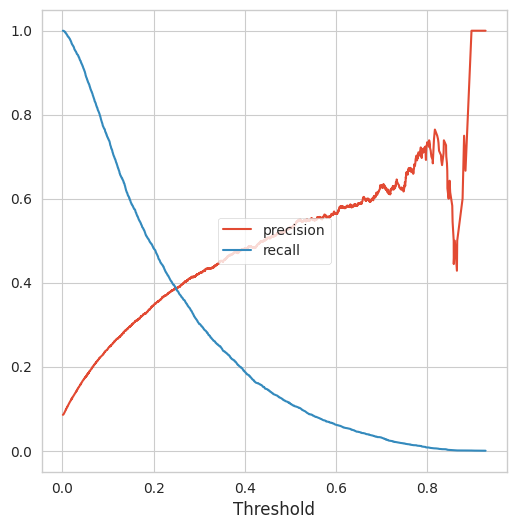

In [89]:
# precision and recall curves
y_pred_proba = (log_reg.predict_proba(X_train_scaled)[:,1])

precision, recall, threshold = precision_recall_curve(y_train, y_pred_proba)

f, ax = plt.subplots(figsize=(6, 6))
plt.plot(threshold, precision[1:],label='precision')
plt.plot(threshold, recall[1:], label='recall')
plt.legend(loc='center')
plt.xlabel('Threshold');
# plt.title('Precision and Recall Curves (X_scaled_train, y)')
plt.savefig("precision-recall-curves.jpeg");

In [96]:
log_reg_pr = LogisticRegression()
log_reg_pr.fit(X_train_scaled, y_train)
y_pred_log_reg_pr = (log_reg_pr.predict_proba(X_val_scaled)[:,1] >= 0.25)
log_reg_pr

LogisticRegression()

In [97]:
fifteen = ["Logistic regression threshold >= 0.25", 'log_reg_pr',
        'Recall:', round(recall_score(y_val, y_pred_log_reg_pr), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_log_reg_pr), 4)]
fifteen

['Logistic regression threshold >= 0.25',
 'log_reg_pr',
 'Recall:',
 0.3671,
 'ROC AUC:',
 0.6541]

## 16 Logistic regression: GridSearchCV

In [77]:
# find best C params and penalty type
grid={"C": np.logspace(-3,3,7), "penalty":["l1","l2"]}# L1 lasso, L2 ridge
logreg = LogisticRegression()
logregcv = GridSearchCV(logreg, grid, cv=10)
logregcv.fit(X_train,y_train)

print("Tuned Hpyerparameters :(best parameters) ", logregcv.best_params_)
print("Best score :", logregcv.best_score_)

Tuned Hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
Best score : 0.9151012407603701


In [98]:
# score model on X_val with best GridSearchCV params
log_reg_gridcv = LogisticRegression(C=0.001, penalty="l2")
log_reg_gridcv.fit(X_train_scaled, y_train)
y_pred_log_reg_gridcv = log_reg_gridcv.predict(X_val_scaled)
log_reg_gridcv

LogisticRegression(C=0.001)

In [99]:
sixteen = ['Log reg GridSearchCV',
             'log_reg_gridcv',
        'Recall:', round(recall_score(y_val, y_pred_log_reg_gridcv), 4),
        'ROC AUC:',round(roc_auc_score(y_val, y_pred_log_reg_gridcv), 4)]
sixteen

['Log reg GridSearchCV',
 'log_reg_gridcv',
 'Recall:',
 0.0833,
 'ROC AUC:',
 0.5387]

## 17 Logistic regression: GridSearchCV + threshold >= 0.25

In [100]:
# score model on X_val with best GridSearchCV params and threshold >= 0.25
log_reg_gridcv_2 = LogisticRegression(C=0.001, penalty="l2")
log_reg_gridcv_2.fit(X_train_scaled, y_train)
y_pred_log_reg_gridcv_2 = (log_reg_gridcv_2.predict_proba(X_val_scaled)[:,1] >= 0.25)
log_reg_gridcv_2

LogisticRegression(C=0.001)

In [101]:
seventeen = ['Log reg GridSearchCV + threshold >= 0.25',
            'log_reg_gridcv_2',
            'Recall:', round(recall_score(y_val, y_pred_log_reg_gridcv_2), 4),
            'ROC AUC:',round(roc_auc_score(y_val, y_pred_log_reg_gridcv_2), 4)]
seventeen

['Log reg GridSearchCV + threshold >= 0.25',
 'log_reg_gridcv_2',
 'Recall:',
 0.3158,
 'ROC AUC:',
 0.6349]

#**9 | Model: Predicting Heart Disease**

## 9.1 Select Model

In [104]:
# df to summarize performance of 18 models
models = [zero, one, two, three, four, five, six, seven, eight,
          nine,ten, eleven, twelve, thirteen, fourteen, fifteen,
          sixteen, seventeen]
model_eval = pd.DataFrame(data = models)

model_eval = model_eval.drop([2,4], axis=1)
model_eval.head(1)

,0,1,3,5
0,Baseline logistic regression,log_reg_base,0.0247,0.5104


In [105]:
model_eval = model_eval.rename(columns={0:'Model',1: 'Variable', 3: 'Recall',5:'ROC AUC'})

In [106]:
# sort by recall and ROC AUC, return top two models
model_eval.sort_values(by=['Recall', 'ROC AUC'], ascending=False).head(1)

,Model,Variable,Recall,ROC AUC
8,Gaussian NB,gaus,0.4763,0.6777



*   Best perfoming model: `log_reg_gridcv`
*   Recall = 0.9116
*   ROC AUC = 0.7459







## 9.2 Evaluate Model

In [108]:
heart_disease_model = LogisticRegression(C=0.001, penalty="l2")
heart_disease_model.fit(X_val_scaled, y_val)
y_pred = (heart_disease_model.predict_proba(X_val_scaled)[:,1] >= 0.05)
heart_disease_model

LogisticRegression(C=0.001)

In [110]:
score = {
    'Model': 'heart_disease_model on test_scaled data',
    'Variable': 'heart_disease_model',
    'Recall': round(recall_score(y_val, y_pred), 4),
    'ROC AUC': round(roc_auc_score(y_val, y_pred), 4)}
score

{'Model': 'heart_disease_model on test_scaled data',
 'Variable': 'heart_disease_model',
 'Recall': 0.9507,
 'ROC AUC': 0.7093}

##### Confusion Matrix


In [111]:
cm = confusion_matrix(y_val, y_pred)
cm

array([[7610, 8652],
       [  74, 1427]])

In [113]:
# classification report
y_pred = heart_disease_model.predict(X_val_scaled)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     16262
         1.0       0.54      0.04      0.07      1501

    accuracy                           0.92     17763
   macro avg       0.73      0.52      0.51     17763
weighted avg       0.89      0.92      0.88     17763



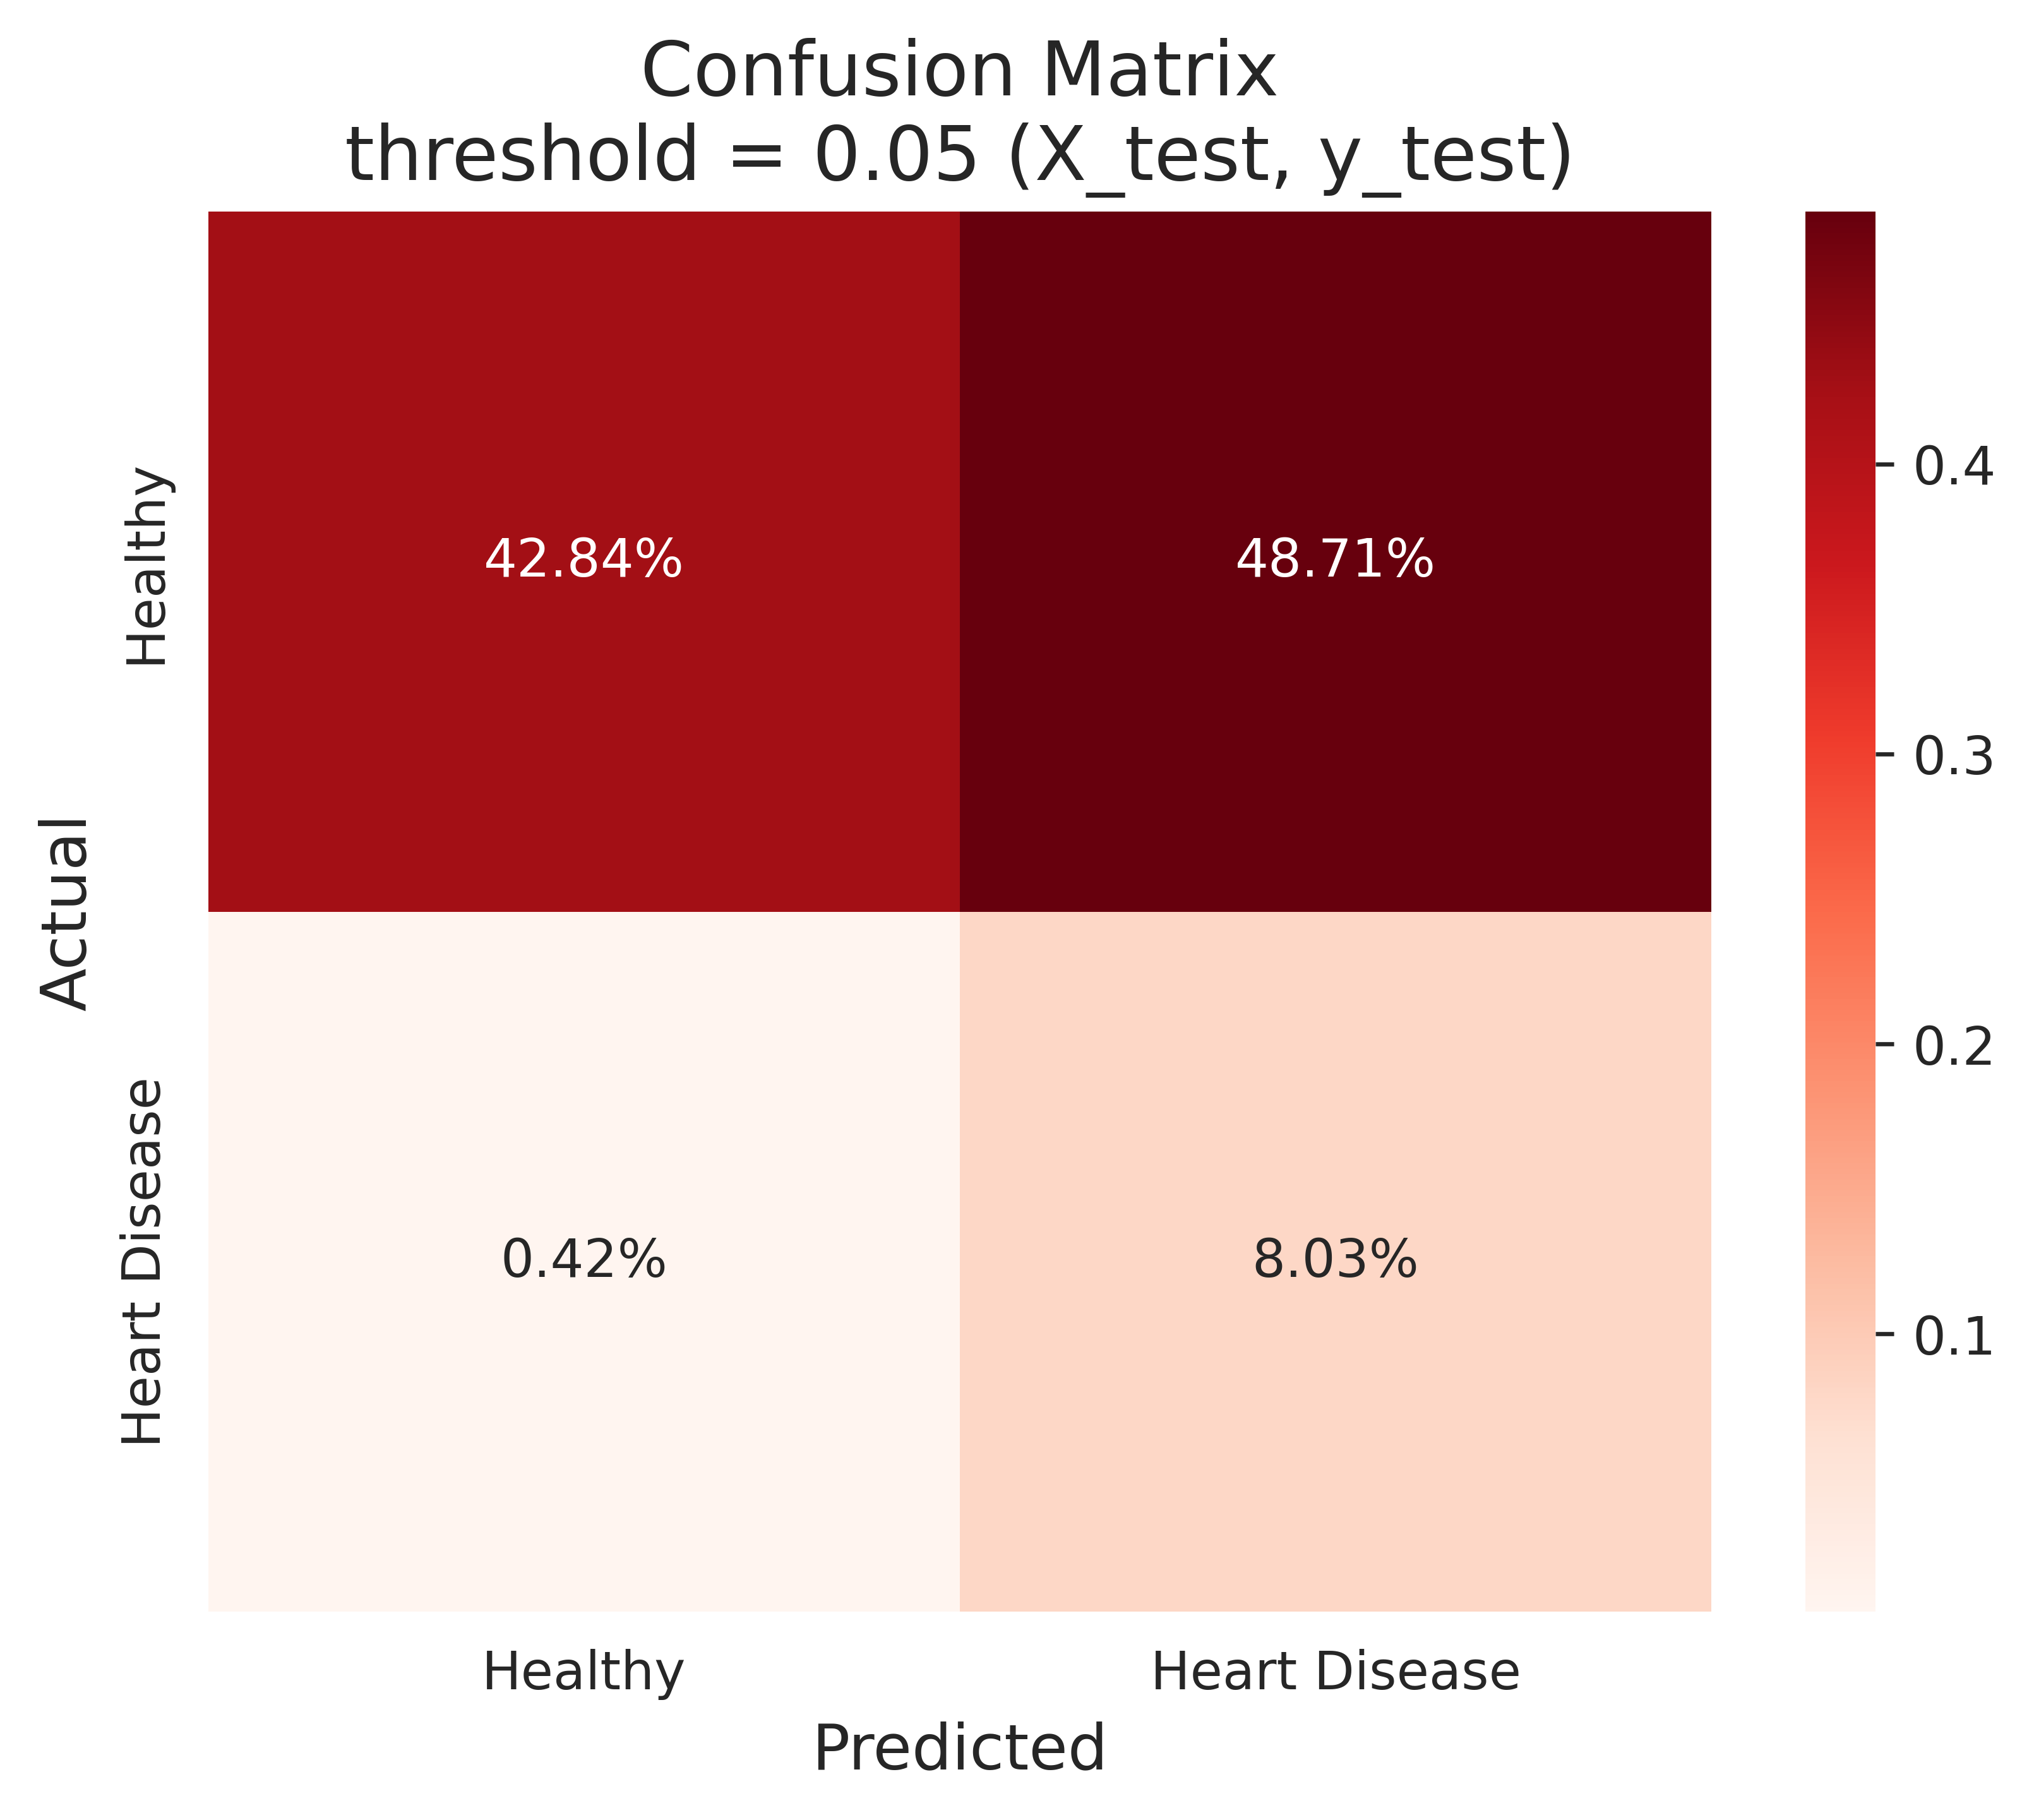

In [114]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Reds')
ax.xaxis.set_ticklabels(['Healthy','Heart Disease'])
ax.yaxis.set_ticklabels(['Healthy','Heart Disease'])

plt.title('Confusion Matrix' '\n' 'threshold = 0.05 (X_test, y_test)')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.savefig("confusion-matrix.jpeg");

In [116]:
# probs = heart_disease_model.predict_proba(X)
# preds = probs[:,1]
# fpr, tpr, threshold = roc_curve(y, preds)
# roc_auc = auc(fpr, tpr)

# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])

# plt.title('ROC AUC Curve (X, y)')
# plt.legend(loc = 'lower right')
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.savefig("roc-auc-curve.jpeg");

## 9.3 Correlations

In [ ]:
heart_disease_df_map.corr().style.background_gradient(cmap='Blues')

## 9.4 Predictions


Value references in [data dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf) and [MVP transformations](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb).

In [ ]:
# refit model to make predictions on `heart_disease_df_map X and y (not scaled)`
heart_disease_model.fit(X, y)
y_pred = (heart_disease_model.predict_proba(X)[:,1] >= 0.5)
heart_disease_model

In [ ]:
sample_df = heart_disease_df_map.sample(3)
sample_df.drop(columns=['behaviors', 'demographics', 'disease', 'measures', 'risk_factors'], inplace=True)

In [ ]:
# separate target from features
y_sample_df = sample_df['y_heart_disease']
X_sample_df = sample_df.drop(['y_heart_disease'], axis=1)

In [ ]:
X_1 = X_sample_df.iloc[[0]]

prediction_1 = [
    sample_df.iloc[0,4],
    sample_df.iloc[0,12],
    int(heart_disease_model.predict(X_1)),
    np.round(heart_disease_model.predict_proba(X_1), 2),
    y_sample_df.iloc[0]
    ]

In [ ]:
X_2 = X_sample_df.iloc[[1]]

prediction_2 = [
    sample_df.iloc[1,4],
    sample_df.iloc[1,12],
    int(heart_disease_model.predict(X_2)),
    np.round(heart_disease_model.predict_proba(X_2), 2),
    y_sample_df.iloc[1]
    ]

In [ ]:
X_3 = X_sample_df.iloc[[2]]

prediction_3 = [
    sample_df.iloc[2,4],
    sample_df.iloc[2,12],
    int(heart_disease_model.predict(X_3)),
    np.round(heart_disease_model.predict_proba(X_3), 2),
    y_sample_df.iloc[2]
    ]

In [ ]:
predictions = [prediction_1, prediction_2, prediction_3]
predictions_df = pd.DataFrame(data=predictions)
predictions_df = predictions_df.rename(columns={0: 'age', 1:'bmi', 2:'y_pred', 3:'y_prob', 4:'y_true' })
predictions_df